In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
from datetime import datetime
import settings.config_movie_lens as cfg
import pandas as pd
import numpy as np

pd.options.display.max_rows = 500 #Changes the number of rows diplayed (default is 60)


preprocessed_dataset_folder = cfg.preprocessed_dataset_folder
recommendations_number = cfg.recommendations_number
group_types = cfg.group_types

'ml-1m'

'preprocessed_dataset'

In [36]:
cfg.top_k = None # Predict for everything, do not restrict anything

In [38]:
similarity_raw_to_name = {
    "Pearson's Correlation Coeficient FULL": "sim_full",
    "Pearson's Correlation Coeficient TRAIN": "sim_train",
    "Biased MF Cosine": "sim_biased_mf_cos",
    "Biased MF L2": "sim_biased_mf_l2",
    "Implicit MF Cosine": "sim_implicit_mf_cos",
    "Implicit MF L2": "sim_implicit_mf_l2"
}

# Camera-ready renames
rename_d = {'sim_full': 'PCC_full',
 'sim_train': 'PCC_train',
 'sim_biased_mf_cos': 'COS_biasMF',
 'sim_biased_mf_l2': 'L2_biasMF',
 'sim_implicit_mf_cos': 'COS_implMF',
 'sim_implicit_mf_l2': 'L2_implMF'}

In [39]:
import pandas as pd
ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv")

import pickle

group_compositions = {}
for sim_name in similarity_raw_to_name.values():
    group_compositions[sim_name] = pickle.load(open(preprocessed_dataset_folder+f"/group_composition_{sim_name}.pkl", "rb"))

## Custom GRS evaluation

In [40]:
from synthetic_groups_generation.groups_generators import Outliers

In [41]:
path_to_fold = f"{preprocessed_dataset_folder}/singlefold"
test_pred_dfs = pickle.load(open(path_to_fold+"/test_pred_dfs.pkl", "rb"))

In [42]:
test_df = pickle.load(open(preprocessed_dataset_folder+"/test_df.pkl", "rb"))

In [43]:
import os 
all_group_recommendations = {}
for algo_name, tst_pred_df in test_pred_dfs.items():
    for sim_name, group_comp in group_compositions.items():
        for pred_k in cfg.recommendations_number:
            path = path_to_fold+"/"+f"predk{pred_k}_group_recommendations_{sim_name}_{algo_name}.pkl"
            if not os.path.exists(path):
                continue
            group_rec = pickle.load(open(path, "rb"))
            all_group_recommendations[f"predk{pred_k}_group_recommendations_{sim_name}_{algo_name}"] = group_rec

In [19]:
def evaluate_outlier_pov(group_id, outlier_id, g_comp, g_rec, ground_truth):
    group_ground_truth = ground_truth.loc[ground_truth['user'].isin(g_comp[group_id]['group_members'])]
    group_rec = g_rec[group_id]
    
    from evaluation_metrics.metric_evaluators import MetricEvaluator, NDCGEvaluator, BinaryEvaluator
    metric_evaluator = BinaryEvaluator()# MetricEvaluator.getMetricEvaluator("NDCG")
    
    user_ground_truth = group_ground_truth.loc[group_ground_truth['user'] == outlier_id]
    user_ground_truth.set_index("item", inplace=True)
    user_ground_truth = user_ground_truth.rename(columns={"rating": "final_rating"})

    #qt = QuantileTransformer(n_quantiles=user_ground_truth["final_rating"].size)
    #sub = user_ground_truth.loc[user_ground_truth.final_rating > 0]
    #qt = qt.fit(sub["final_rating"].values.reshape(-1, 1))
    #user_ground_truth.loc[:, "final_rating"] = qt.transform(user_ground_truth["final_rating"].values.reshape(-1, 1))
    bn = BinaryEvaluator()
    
    hits_and_ratings = {}
    for algo, gr in group_rec.items():
        xx = user_ground_truth[user_ground_truth.final_rating > 0]
        raw = [xx.loc[item].final_rating if item in xx.index else 0.0 for item in gr]
        hits_and_ratings[algo] = {
            #"raw": raw,
            "sum_ratings": sum(raw),
            "mean_rating": sum(raw)/len(raw),
            "hit_rate": sum([1 if x > 0 else 0 for x in raw]) / len(raw),
            "thresh_hit_rate": sum([1 if x >= 0.8 else 0 for x in raw]) / len(raw)
        }
        
        
    return {
        algo: bn.evaluateUserBinary(user_ground_truth, gr, 1.0) for algo, gr in group_rec.items()
    }, hits_and_ratings

In [20]:
from sklearn.preprocessing import QuantileTransformer

In [21]:
import matplotlib.pyplot as plt

In [24]:
import time

outlier_avgs = {}
non_outlier_avgs = {}

outlier_sizes = {}
non_outlier_sizes = {}

for mtr in ["sim_full", "sim_train", "sim_biased_mf_cos", "sim_biased_mf_l2", "sim_implicit_mf_cos", "sim_implicit_mf_l2"]:

    start_time = time.perf_counter()
    
    n_outliers = 0
    total_outlier_size = 0

    n_non_outliers = 0
    total_non_outlier_size = 0
    
    individual_outlier_sizes = []
    individual_non_outlier_sizes = []
    
    grc = group_compositions[mtr]
    for i in range(2400, 3600): # Take all similar_with_centered_outliers with all group sizes  #range(2400, 2600):
        grp = grc[i]
        grp_size = grp["group_size"]
        
        outs = Outliers.get_num_outliers(grp_size)
        
        outliers = grp["group_members"][:outs]
        not_outliers = grp["group_members"][outs:]
        
        n_outliers += outs
        n_non_outliers += len(not_outliers)
        
        for outlier in outliers:
            out_siz = test_df[(test_df.user == outlier)].shape[0]
            total_outlier_size += out_siz
            individual_outlier_sizes.append(out_siz)
        
        for non_out in not_outliers:
            non_out_siz = test_df[(test_df.user == non_out)].shape[0]
            total_non_outlier_size += non_out_siz
            individual_non_outlier_sizes.append(non_out_siz)
            
    print(f"Test set size for similarity={mtr}, on group_size=4")
    print(f"OUTLIERS={n_outliers}, total={total_outlier_size}, avg_per={total_outlier_size/n_outliers}")
    print(f"NON-OUTLIERS={n_non_outliers}, total={total_non_outlier_size}, avg_per={total_non_outlier_size/n_non_outliers}")
    print("####\n")
    
    print(f"Single metric took: {time.perf_counter() - start_time}")
        
    outlier_avgs[mtr] = total_outlier_size/n_outliers
    non_outlier_avgs[mtr] = total_non_outlier_size/n_non_outliers
    
    outlier_sizes[mtr] = individual_outlier_sizes
    non_outlier_sizes[mtr] = individual_non_outlier_sizes

Test set size for similarity=sim_full, on group_size=4
OUTLIERS=3600, total=206195, avg_per=57.27638888888889
NON-OUTLIERS=29600, total=1449207, avg_per=48.959695945945946
####

Single metric took: 16.458802499999933
Test set size for similarity=sim_train, on group_size=4
OUTLIERS=3600, total=198705, avg_per=55.19583333333333
NON-OUTLIERS=29600, total=1115476, avg_per=37.685
####

Single metric took: 15.69402249999996
Test set size for similarity=sim_biased_mf_cos, on group_size=4
OUTLIERS=3600, total=278665, avg_per=77.40694444444445
NON-OUTLIERS=29600, total=1298391, avg_per=43.86456081081081
####

Single metric took: 15.999559699999963
Test set size for similarity=sim_biased_mf_l2, on group_size=4
OUTLIERS=3600, total=45000, avg_per=12.5
NON-OUTLIERS=29600, total=1860549, avg_per=62.856385135135135
####

Single metric took: 15.09603949999996
Test set size for similarity=sim_implicit_mf_cos, on group_size=4
OUTLIERS=3600, total=18200, avg_per=5.055555555555555
NON-OUTLIERS=29600, tot

In [25]:
dt_outliers = pd.DataFrame.from_dict(outlier_avgs, orient="index")
dt_outliers.loc[:, "membership kind"] = "outlier"

dt_non_outliers = pd.DataFrame.from_dict(non_outlier_avgs, orient="index")
dt_non_outliers.loc[:, "membership kind"] = "majority"

dt = pd.concat([dt_outliers, dt_non_outliers], axis=0).rename(columns={0: "Test set size"})
dt.loc[:, "metric"] = dt.index
dt

,Test set size,membership kind,metric
sim_full,57.276389,outlier,sim_full
sim_train,55.195833,outlier,sim_train
sim_biased_mf_cos,77.406944,outlier,sim_biased_mf_cos
sim_biased_mf_l2,12.500000,outlier,sim_biased_mf_l2
sim_implicit_mf_cos,5.055556,outlier,sim_implicit_mf_cos
sim_implicit_mf_l2,273.410556,outlier,sim_implicit_mf_l2
sim_full,48.959696,majority,sim_full
sim_train,37.685000,majority,sim_train
sim_biased_mf_cos,43.864561,majority,sim_biased_mf_cos
sim_biased_mf_l2,62.856385,majority,sim_biased_mf_l2


In [26]:
df_out_sizes = pd.DataFrame.from_dict(outlier_sizes)
df_out_sizes.loc[:, "membership kind"] = "outlier"

dt_non_out_sizes = pd.DataFrame.from_dict(non_outlier_sizes)
dt_non_out_sizes.loc[:, "membership kind"] = "majority"

dt = pd.concat([df_out_sizes, dt_non_out_sizes], axis=0).rename(columns={0: "Test set size"})

y1 = pd.DataFrame(dt.loc[:, ["sim_full", "membership kind"]]).rename(columns={"sim_full": "Test data size"})
y1.loc[:, "similarity"] = "sim_full"

y2 = pd.DataFrame(dt.loc[:, ["sim_train", "membership kind"]]).rename(columns={"sim_train": "Test data size"})
y2.loc[:, "similarity"] = "sim_train"

y3 = pd.DataFrame(dt.loc[:, ["sim_biased_mf_cos", "membership kind"]]).rename(columns={"sim_biased_mf_cos": "Test data size"})
y3.loc[:, "similarity"] = "sim_biased_mf_cos"

y4 = pd.DataFrame(dt.loc[:, ["sim_biased_mf_l2", "membership kind"]]).rename(columns={"sim_biased_mf_l2": "Test data size"})
y4.loc[:, "similarity"] = "sim_biased_mf_l2"

y5 = pd.DataFrame(dt.loc[:, ["sim_implicit_mf_cos", "membership kind"]]).rename(columns={"sim_implicit_mf_cos": "Test data size"})
y5.loc[:, "similarity"] = "sim_implicit_mf_cos"

y6 = pd.DataFrame(dt.loc[:, ["sim_implicit_mf_l2", "membership kind"]]).rename(columns={"sim_implicit_mf_l2": "Test data size"})
y6.loc[:, "similarity"] = "sim_implicit_mf_l2"

full_df = pd.concat([y1, y2, y3, y4, y5, y6]).reset_index()
full_df

,index,Test data size,membership kind,similarity
0,0,196,outlier,sim_full
1,1,46,outlier,sim_full
2,2,23,outlier,sim_full
3,3,140,outlier,sim_full
4,4,36,outlier,sim_full
...,...,...,...,...
199195,29595,9,majority,sim_implicit_mf_l2
199196,29596,9,majority,sim_implicit_mf_l2
199197,29597,4,majority,sim_implicit_mf_l2
199198,29598,6,majority,sim_implicit_mf_l2


In [27]:
def increase_font_size(scale=1.5):
    font_keys = ["axes.labelsize", "axes.titlesize", "legend.fontsize",
             "xtick.labelsize", "ytick.labelsize", "font.size"]
    font_dict = {k: matplotlib.rcParams[k] * scale if k == "font.size" else "x-large" for k in font_keys}
    matplotlib.rcParams.update(font_dict)

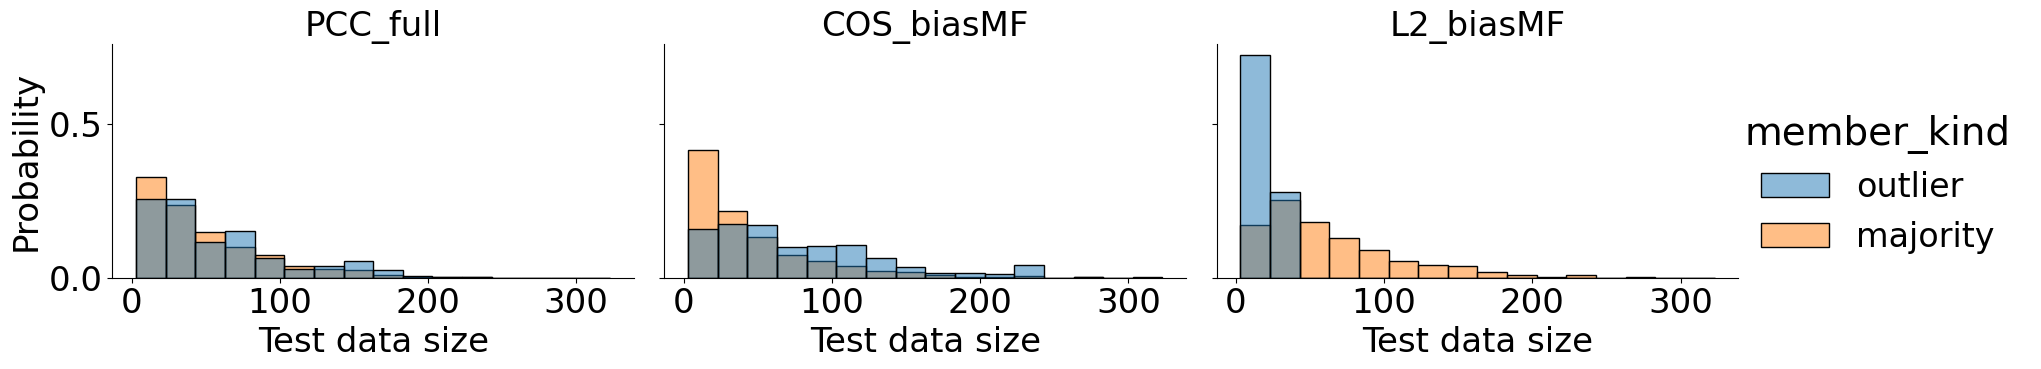

In [82]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
full_df_sub1 = full_df[full_df.similarity.isin(["sim_full", "sim_biased_mf_l2", "sim_biased_mf_cos"])]
full_df_sub1 = full_df_sub1.replace(rename_d).rename(columns={"membership kind": "member_kind"})
sns.reset_defaults()
increase_font_size(1.7)

g = sns.displot(
    data=full_df_sub1,
    x="Test data size", bins="auto", hue="member_kind", stat="probability", col=full_df_sub1.similarity,
    common_norm=False, binwidth=20, height=4, aspect=1.5
)
g.set_titles(col_template="{col_name}")
plt.setp(g._legend.get_title(), fontsize=28)
plt.setp(g._legend.get_texts(), fontsize=24)
plt.savefig(f"results/test_sizes_distr1_camera_ready.pdf")

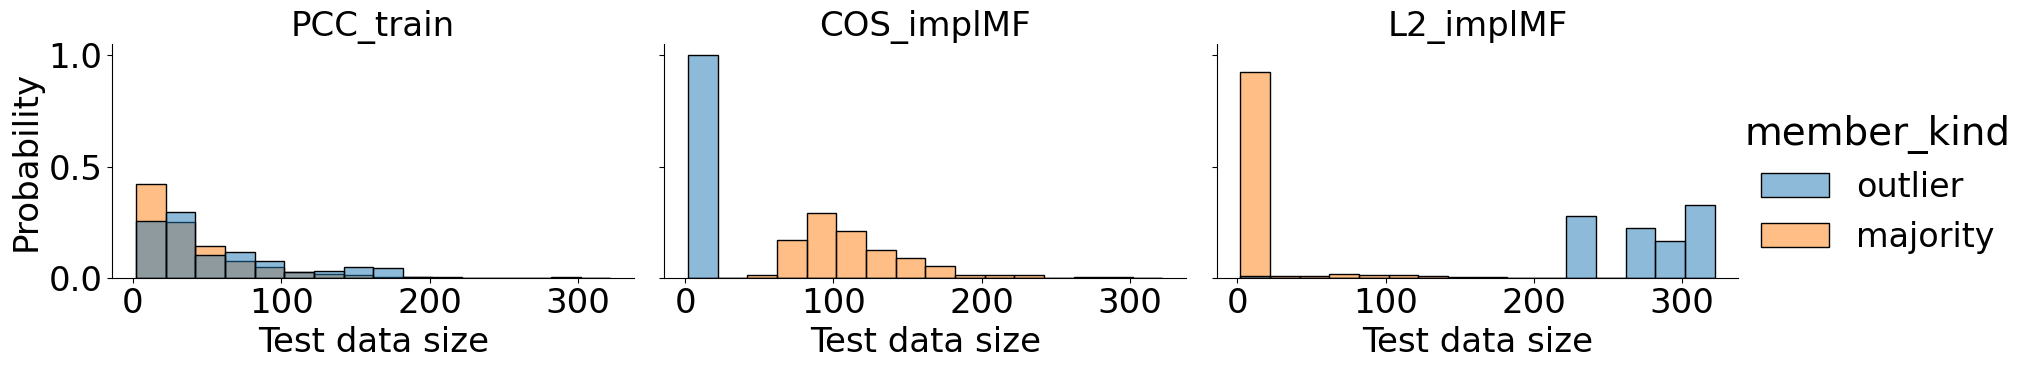

In [81]:
full_df_sub2 = full_df[full_df.similarity.isin(["sim_train", "sim_implicit_mf_l2", "sim_implicit_mf_cos"])]
full_df_sub2 = full_df_sub2.replace(rename_d).rename(columns={"membership kind": "member_kind"})
sns.reset_defaults()
increase_font_size(1.7)
g = sns.displot(
    data=full_df_sub2.replace(rename_d),
    x="Test data size", bins="auto", hue="member_kind", stat="probability", col=full_df_sub2.similarity,
    common_norm=False, binwidth=20, height=4, aspect=1.5
)
g.set_titles(col_template="{col_name}")
plt.setp(g._legend.get_title(), fontsize=28)
plt.setp(g._legend.get_texts(), fontsize=24)
plt.savefig(f"results/test_sizes_distr2_camera_ready.pdf")

In [31]:
from matplotlib.ticker import StrMethodFormatter
def calc_group(group_id, g_comp, g_rec, metric_key, ground_truth):
    g = g_comp[group_id]

    rs_outliers = {
        algo: {
            "mean_rating": 0,
            "hit_rate": 0,
            "sum_ratings": 0,
            "thresh_hit_rate": 0,
            "hits": [],
            "hit_variance": 0.0
        }
        for algo in g_rec[group_id].keys()
    }
    rs_no_outliers = {
        algo: {
            "mean_rating": 0,
            "hit_rate": 0,
            "sum_ratings": 0,
            "thresh_hit_rate": 0,
            "hits": [],
            "hit_variance": 0.0
        }
        for algo in g_rec[group_id].keys()
    }
    rs_overall = {
        algo: {
            "mean_rating": 0,
            "hit_rate": 0,
            "sum_ratings": 0,
            "thresh_hit_rate": 0,
            "hits": [],
            "hit_variance": 0.0
        }
        for algo in g_rec[group_id].keys()
    }


    gs = len(g["group_members"])
    n_outliers = Outliers.get_num_outliers(gs)
    for i in range(gs):
        if i < n_outliers:
            for algo, r in evaluate_outlier_pov(group_id, g["group_members"][i], g_comp, g_rec, ground_truth)[1].items():
                for k, v in r.items():
                    rs_outliers[algo][k] += v
                    rs_overall[algo][k] += v
                    
                    if k == "hit_rate":
                        rs_outliers[algo]["hits"].append(v)
                        rs_overall[algo]["hits"].append(v)
        else:
            for algo, r in evaluate_outlier_pov(group_id, g["group_members"][i], g_comp, g_rec, ground_truth)[1].items():
                for k, v in r.items():
                    rs_no_outliers[algo][k] += v
                    rs_overall[algo][k] += v
                    
                    if k == "hit_rate":
                        rs_no_outliers[algo]["hits"].append(v)
                        rs_overall[algo]["hits"].append(v)

    # Calculate means and variances for outlier results
    for algo, r in rs_outliers.items():
        for k, v in r.items():
            if k == "hits":
                continue
            elif k == "hit_variance":
                #print(f"Outlier hit variance: {np.var(rs_outliers[algo]['hits'])} for hits: {rs_outliers[algo]['hits']}")
                rs_outliers[algo][k] = np.var(rs_outliers[algo]["hits"])
            else:
                rs_outliers[algo][k] = v / n_outliers
        #print(algo, rs_outliers[algo])

    # Calculate means and variances for non-outlier results
    for algo, r in rs_no_outliers.items():
        for k, v in r.items():
            if k == "hits":
                continue
            elif k == "hit_variance":
                #print(f"NON Outlier hit variance: {np.var(rs_no_outliers[algo]['hits'])} for hits: {rs_no_outliers[algo]['hits']}")
                rs_no_outliers[algo][k] = np.var(rs_no_outliers[algo]["hits"])
            else:
                rs_no_outliers[algo][k] = v / (gs - n_outliers)
                
    # Calculate means and variances for OVERALL results
    for algo, r in rs_overall.items():
        for k, v in r.items():
            if k == "hits":
                continue
            elif k == "hit_variance":
                rs_overall[algo][k] = np.var(rs_overall[algo]["hits"])
            else:
                rs_overall[algo][k] = v / gs

    means_outliers = {algo: r[metric_key] for algo, r in rs_outliers.items()}
    means_no_outliers = {algo: r[metric_key] for algo, r in rs_no_outliers.items()}
    
    # Means without distinction of outlier x no-outlier
    means_overall = {algo: r[metric_key] for algo, r in rs_overall.items()}
    
    return means_outliers, means_no_outliers, means_overall

def calc_groups(group_ids, g_comp, g_rec, metric_key, ground_truth):
    res_outliers = None
    res_no_outliers = None
    res_overall = None
    
    # Sum over all groups
    for group_id in group_ids:
        r1, r2, r3 = calc_group(group_id, g_comp, g_rec, metric_key, ground_truth)
        if res_outliers is None:
            res_outliers = r1
        else:
            for k, v in r1.items():
                res_outliers[k] += v
        
        if res_no_outliers is None:
            res_no_outliers = r2
        else:
            for k, v in r2.items():
                res_no_outliers[k] += v
            
        if res_overall is None:
            res_overall = r3
        else:
            for k, v in r3.items():
                res_overall[k] += v
            
    # Means over all groups
    return {k: v / len(group_ids) for k, v in res_outliers.items()}, \
        {k: v / len(group_ids) for k, v in res_no_outliers.items()}, \
        {k: v / len(group_ids) for k, v in res_overall.items()}
            
def plot_res(res, title):
    plt.figure()
    plt.bar(range(len(res)), list(res.values()), tick_label=list(res.keys()))
    plt.title(title)
    plt.show()
    
def single_plot_res(res_outliers, res_no_outliers, res_overall, metric_key, global_title=""):
    dt_outliers = pd.concat([pd.Series(res_outliers), pd.Series({k: "outlier" for k in res_outliers.keys()})], axis=1)
    dt_no_outliers = pd.concat([pd.Series(res_no_outliers), pd.Series({k: "majority" for k in res_no_outliers.keys()})], axis=1)
    dt_overall = pd.concat([pd.Series(res_overall), pd.Series({k: "overall" for k in res_overall.keys()})], axis=1)
    
    dt = pd.concat([dt_outliers, dt_no_outliers, dt_overall], axis=0).rename(columns={0: metric_key, 1: "membership kind"})
    dt.loc[:, "algorithm"] = dt.rename(index={"EPFuzzDA": "EPFDA", "GreedyLM": "GLM"}).index
    g = sns.catplot(
        data=dt, kind="bar",
        x="algorithm", y=metric_key, hue="membership kind",
        errorbar="sd", palette="deep", height=2.2, aspect=1.8
    )
    
    plt.title(global_title.replace(", biasedMf", "").replace("sim_", ""))
    plt.xticks(rotation=90)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
    
    g._legend.remove()
    g.set(ylim=(0, 0.13 if "sim_implicit_mf_l2, biasedMf" not in global_title else 0.5))
    #sns.move_legend(g, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

    g.set(xlabel=None)
    g.set(ylabel=None)
    global_title_f = global_title.replace("|G|", "group_size")
    plt.savefig(f"results/{global_title_f}.png", bbox_inches='tight')
    plt.savefig(f"results/{global_title_f}.pdf", bbox_inches='tight')
    
def hits_and_variance(group_ids, g_comp, g_rec, global_title, ground_truth):
    hits_outliers, hits_no_outliers, hits_overall = calc_groups(group_ids, g_comp, g_rec, "hit_rate", ground_truth)
    hit_variance_outliers, hit_variance_no_outliers, hit_variance_overall = calc_groups(group_ids, g_comp, g_rec, "hit_variance", ground_truth)
    
    dt_outliers = pd.concat([pd.Series(hits_outliers), pd.Series(hit_variance_outliers), pd.Series({k: "outlier" for k in hits_outliers.keys()})], axis=1)
    dt_no_outliers = pd.concat([pd.Series(hits_no_outliers), pd.Series(hit_variance_no_outliers), pd.Series({k: "non-outlier" for k in hits_no_outliers.keys()})], axis=1)
    dt_overall = pd.concat([pd.Series(hits_overall), pd.Series(hit_variance_overall), pd.Series({k: "overall" for k in hits_overall.keys()})], axis=1)
    
    dt = pd.concat([dt_outliers, dt_no_outliers, dt_overall], axis=0).rename(columns={0: "hit_rate", 1: "hit_variance", 2: "kind"})
    dt.loc[:, "algo"] = dt.index
    g = sns.catplot(
        data=dt, kind="bar",
        x="algo", y="hit_rate", hue="kind",
        errorbar="sd", palette="dark", alpha=.6, height=6
    )
    plt.title(global_title)
    
    g = sns.catplot(
        data=dt, kind="bar",
        x="algo", y="hit_variance", hue="kind",
        errorbar="sd", palette="dark", alpha=.6, height=6
    )
    plt.title(global_title)
    
    
def plot_group(group_id, g_comp, g_rec, ground_truth):
    mean_outliers, mean_no_outliers, mean_overall = calc_group(group_id, g_comp, g_rec, ground_truth)
    
    plot_res(mean_outliers, "Mean rating of outliers")
    plot_res(mean_no_outliers, "Mean rating of NO outliers")
    plot_res(mean_overall, "Mean rating of OVERALL group")
    

In [15]:
test_df = pickle.load(open(preprocessed_dataset_folder+"/test_df.pkl", "rb"))

## New results from here

Evaluation type == COUPLED
Algo_name == biasedMf
Generating: predk10_group_recommendations_sim_full_biasedMf
Done Generating: predk10_group_recommendations_sim_full_biasedMf
Generating: predk10_group_recommendations_sim_train_biasedMf
Done Generating: predk10_group_recommendations_sim_train_biasedMf
Generating: predk10_group_recommendations_sim_biased_mf_cos_biasedMf
Done Generating: predk10_group_recommendations_sim_biased_mf_cos_biasedMf
Generating: predk10_group_recommendations_sim_biased_mf_l2_biasedMf
Done Generating: predk10_group_recommendations_sim_biased_mf_l2_biasedMf
Generating: predk10_group_recommendations_sim_implicit_mf_cos_biasedMf
Done Generating: predk10_group_recommendations_sim_implicit_mf_cos_biasedMf
Generating: predk10_group_recommendations_sim_implicit_mf_l2_biasedMf
Done Generating: predk10_group_recommendations_sim_implicit_mf_l2_biasedMf
Algo_name == implicitMf


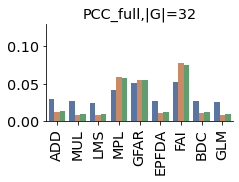

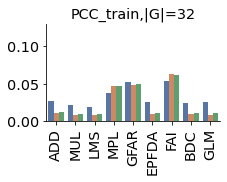

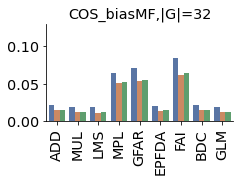

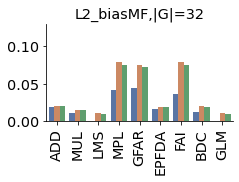

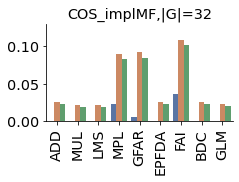

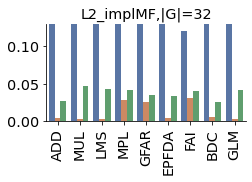

In [88]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
metric = "hit_rate"

# Decoupled
#topk_test_pred_df = pickle.load(open(path_to_fold+"/topk"+str(current_topk)+"_test_pred_df.pkl", "rb"))
#ground_truth = topk_test_pred_df.rename(columns={"predicted_rating": "rating"}, errors="raise")

# Coupled
test_df = pickle.load(open(preprocessed_dataset_folder+"/test_df.pkl", "rb"))
#ground_truth = test_df

for eval_type in ["COUPLED"]: #, "DECOUPLED"]:
    print(f"Evaluation type == {eval_type}")
    for algo_name, test_pred_df in test_pred_dfs.items():
        print(f"Algo_name == {algo_name}")
        if algo_name == "implicitMf":
            continue # We skip this for the paper
        if eval_type == "COUPLED":
            ground_truth = test_df
        elif eval_type == "DECOUPLED":
            ground_truth = test_pred_df.rename(columns={"predicted_rating": "rating"}, errors="raise")
            ground_truth.loc[:, "rating"] = ground_truth.loc[:, "rating"] >= 4.0
        
        for sim_name, g_comp in group_compositions.items():
            g_comp = group_compositions[sim_name]
            for pred_k in [10]: # We are now only interested in top-10 #cfg.recommendations_number:
                group_recommendation_name = f"predk{pred_k}_group_recommendations_{sim_name}_{algo_name}"
                print(f"Generating: {group_recommendation_name}")
                if not group_recommendation_name in all_group_recommendations:
                    continue
                g_rec = all_group_recommendations[group_recommendation_name]
                r_outliers, r_no_outliers, r_overall = calc_groups(range(3200, 3400), g_comp, g_rec, metric, ground_truth)

                ttle = f"{rename_d[sim_name]}, {algo_name},|G|=32"
                single_plot_res(r_outliers, r_no_outliers, r_overall, metric, ttle)
                print(f"Done Generating: {group_recommendation_name}")
                

Evaluation type == COUPLED
Algo_name == biasedMf
Generating: predk10_group_recommendations_sim_full_biasedMf
Done Generating: predk10_group_recommendations_sim_full_biasedMf
Generating: predk10_group_recommendations_sim_train_biasedMf
Done Generating: predk10_group_recommendations_sim_train_biasedMf
Generating: predk10_group_recommendations_sim_biased_mf_cos_biasedMf
Done Generating: predk10_group_recommendations_sim_biased_mf_cos_biasedMf
Generating: predk10_group_recommendations_sim_biased_mf_l2_biasedMf
Done Generating: predk10_group_recommendations_sim_biased_mf_l2_biasedMf
Generating: predk10_group_recommendations_sim_implicit_mf_cos_biasedMf
Done Generating: predk10_group_recommendations_sim_implicit_mf_cos_biasedMf
Generating: predk10_group_recommendations_sim_implicit_mf_l2_biasedMf
Done Generating: predk10_group_recommendations_sim_implicit_mf_l2_biasedMf
Algo_name == implicitMf


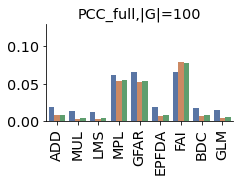

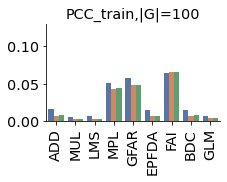

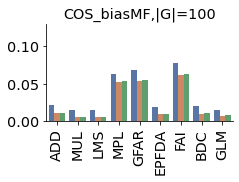

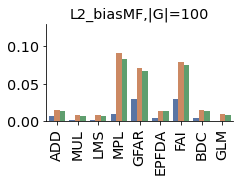

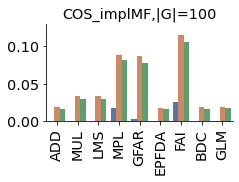

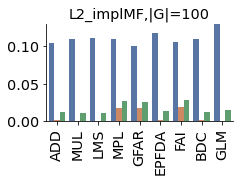

In [87]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
metric = "hit_rate"

# Decoupled
#topk_test_pred_df = pickle.load(open(path_to_fold+"/topk"+str(current_topk)+"_test_pred_df.pkl", "rb"))
#ground_truth = topk_test_pred_df.rename(columns={"predicted_rating": "rating"}, errors="raise")

# Coupled
test_df = pickle.load(open(preprocessed_dataset_folder+"/test_df.pkl", "rb"))
#ground_truth = test_df

for eval_type in ["COUPLED"]: #, "DECOUPLED"]:
    print(f"Evaluation type == {eval_type}")
    for algo_name, test_pred_df in test_pred_dfs.items():
        print(f"Algo_name == {algo_name}")
        if algo_name == "implicitMf":
            continue # We skip this for the paper
        if eval_type == "COUPLED":
            ground_truth = test_df
        elif eval_type == "DECOUPLED":
            ground_truth = test_pred_df.rename(columns={"predicted_rating": "rating"}, errors="raise")
            ground_truth.loc[:, "rating"] = ground_truth.loc[:, "rating"] >= 4.0
        
        for sim_name, g_comp in group_compositions.items():
            g_comp = group_compositions[sim_name]
            for pred_k in [10]: # We are now only interested in top-10 #cfg.recommendations_number:
                group_recommendation_name = f"predk{pred_k}_group_recommendations_{sim_name}_{algo_name}"
                print(f"Generating: {group_recommendation_name}")
                if not group_recommendation_name in all_group_recommendations:
                    continue
                g_rec = all_group_recommendations[group_recommendation_name]
                r_outliers, r_no_outliers, r_overall = calc_groups(range(3400, 3600), g_comp, g_rec, metric, ground_truth)

                ttle = f"{rename_d[sim_name]}, {algo_name},|G|=100"
                single_plot_res(r_outliers, r_no_outliers, r_overall, metric, ttle)
                print(f"Done Generating: {group_recommendation_name}")
                

Evaluation type == COUPLED
Algo_name == biasedMf
Generating: predk10_group_recommendations_sim_full_biasedMf
Done Generating: predk10_group_recommendations_sim_full_biasedMf
Generating: predk10_group_recommendations_sim_train_biasedMf
Done Generating: predk10_group_recommendations_sim_train_biasedMf
Generating: predk10_group_recommendations_sim_biased_mf_cos_biasedMf
Done Generating: predk10_group_recommendations_sim_biased_mf_cos_biasedMf
Generating: predk10_group_recommendations_sim_biased_mf_l2_biasedMf
Done Generating: predk10_group_recommendations_sim_biased_mf_l2_biasedMf
Generating: predk10_group_recommendations_sim_implicit_mf_cos_biasedMf
Done Generating: predk10_group_recommendations_sim_implicit_mf_cos_biasedMf
Generating: predk10_group_recommendations_sim_implicit_mf_l2_biasedMf
Done Generating: predk10_group_recommendations_sim_implicit_mf_l2_biasedMf
Algo_name == implicitMf


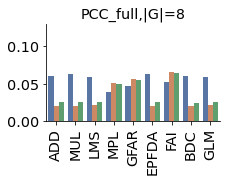

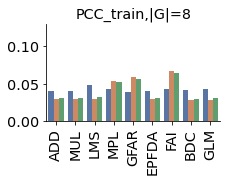

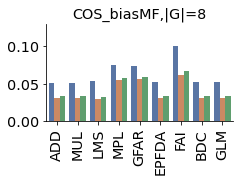

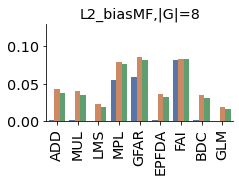

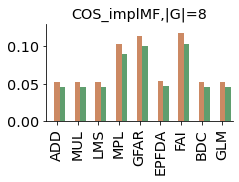

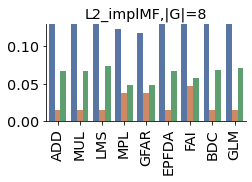

In [86]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
metric = "hit_rate"

# Decoupled
#topk_test_pred_df = pickle.load(open(path_to_fold+"/topk"+str(current_topk)+"_test_pred_df.pkl", "rb"))
#ground_truth = topk_test_pred_df.rename(columns={"predicted_rating": "rating"}, errors="raise")

# Coupled
test_df = pickle.load(open(preprocessed_dataset_folder+"/test_df.pkl", "rb"))
#ground_truth = test_df

for eval_type in ["COUPLED"]: #, "DECOUPLED"]:
    print(f"Evaluation type == {eval_type}")
    for algo_name, test_pred_df in test_pred_dfs.items():
        print(f"Algo_name == {algo_name}")
        if algo_name == "implicitMf":
            continue # We skip this for the paper
        if eval_type == "COUPLED":
            ground_truth = test_df
        elif eval_type == "DECOUPLED":
            ground_truth = test_pred_df.rename(columns={"predicted_rating": "rating"}, errors="raise")
            ground_truth.loc[:, "rating"] = ground_truth.loc[:, "rating"] >= 4.0
        
        for sim_name, g_comp in group_compositions.items():
            g_comp = group_compositions[sim_name]
            for pred_k in [10]: # We are now only interested in top-10 #cfg.recommendations_number:
                group_recommendation_name = f"predk{pred_k}_group_recommendations_{sim_name}_{algo_name}"
                print(f"Generating: {group_recommendation_name}")
                if not group_recommendation_name in all_group_recommendations:
                    continue
                g_rec = all_group_recommendations[group_recommendation_name]
                r_outliers, r_no_outliers, r_overall = calc_groups(range(2800, 3000), g_comp, g_rec, metric, ground_truth)

                ttle = f"{rename_d[sim_name]}, {algo_name},|G|=8"
                single_plot_res(r_outliers, r_no_outliers, r_overall, metric, ttle)
                print(f"Done Generating: {group_recommendation_name}")
                

In [84]:
sns.reset_defaults()

increase_font_size(2)

Evaluation type == COUPLED
Algo_name == biasedMf
Generating: predk10_group_recommendations_sim_full_biasedMf
Done Generating: predk10_group_recommendations_sim_full_biasedMf
Generating: predk10_group_recommendations_sim_train_biasedMf
Done Generating: predk10_group_recommendations_sim_train_biasedMf
Generating: predk10_group_recommendations_sim_biased_mf_cos_biasedMf
Done Generating: predk10_group_recommendations_sim_biased_mf_cos_biasedMf
Generating: predk10_group_recommendations_sim_biased_mf_l2_biasedMf
Done Generating: predk10_group_recommendations_sim_biased_mf_l2_biasedMf
Generating: predk10_group_recommendations_sim_implicit_mf_cos_biasedMf
Done Generating: predk10_group_recommendations_sim_implicit_mf_cos_biasedMf
Generating: predk10_group_recommendations_sim_implicit_mf_l2_biasedMf
Done Generating: predk10_group_recommendations_sim_implicit_mf_l2_biasedMf
Algo_name == implicitMf


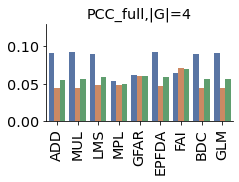

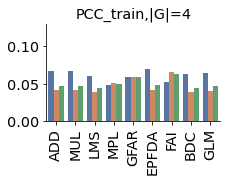

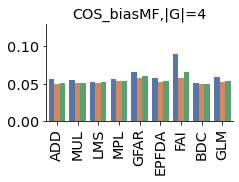

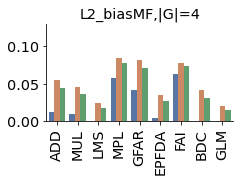

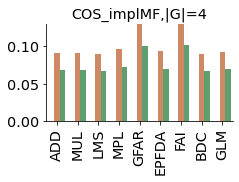

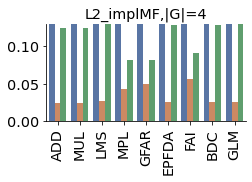

In [85]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
metric = "hit_rate"

# Decoupled
#topk_test_pred_df = pickle.load(open(path_to_fold+"/topk"+str(current_topk)+"_test_pred_df.pkl", "rb"))
#ground_truth = topk_test_pred_df.rename(columns={"predicted_rating": "rating"}, errors="raise")

# Coupled
test_df = pickle.load(open(preprocessed_dataset_folder+"/test_df.pkl", "rb"))
#ground_truth = test_df

for eval_type in ["COUPLED"]: #, "DECOUPLED"]:
    print(f"Evaluation type == {eval_type}")
    for algo_name, test_pred_df in test_pred_dfs.items():
        print(f"Algo_name == {algo_name}")
        if algo_name == "implicitMf":
            continue # We skip this for the paper
        if eval_type == "COUPLED":
            ground_truth = test_df
        elif eval_type == "DECOUPLED":
            ground_truth = test_pred_df.rename(columns={"predicted_rating": "rating"}, errors="raise")
            ground_truth.loc[:, "rating"] = ground_truth.loc[:, "rating"] >= 4.0
        
        for sim_name, g_comp in group_compositions.items():
            g_comp = group_compositions[sim_name]
            for pred_k in [10]: # We are now only interested in top-10 #cfg.recommendations_number:
                group_recommendation_name = f"predk{pred_k}_group_recommendations_{sim_name}_{algo_name}"
                print(f"Generating: {group_recommendation_name}")
                if not group_recommendation_name in all_group_recommendations:
                    continue
                g_rec = all_group_recommendations[group_recommendation_name]
                r_outliers, r_no_outliers, r_overall = calc_groups(range(2400, 2600), g_comp, g_rec, metric, ground_truth)

                ttle = f"{rename_d[sim_name]}, {algo_name},|G|=4"
                single_plot_res(r_outliers, r_no_outliers, r_overall, metric, ttle)
                print(f"Done Generating: {group_recommendation_name}")


## To there